In [4]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib

import matplotlib.pyplot as plt
from scipy.stats import skew
from scipy.stats.stats import pearsonr


%config InlineBackend.figure_format = 'retina' #set 'png' here when working on notebook
%matplotlib inline

In [5]:
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")
all_data=pd.concat((train.loc[:,'MSSubClass':'SaleCondition'],
                      test.loc[:,'MSSubClass':'SaleCondition']))
matplotlib.rcParams['figure.figsize'] = (22.0, 16.0)

prices = pd.DataFrame({"price":train["SalePrice"], "log(price + 1)":np.log1p(train["SalePrice"])})
#prices.hist()

In [6]:
#log transform the target:
train["SalePrice"] = np.log1p(train["SalePrice"])

#log transform skewed numeric features:
numeric_feats = all_data.dtypes[all_data.dtypes != "object"].index

skewed_feats = train[numeric_feats].apply(lambda x: skew(x.dropna())) #compute skewness
skewed_feats = skewed_feats[skewed_feats > 0.75]
skewed_feats = skewed_feats.index
all_data[skewed_feats] = np.log1p(all_data[skewed_feats])
all_data = pd.get_dummies(all_data)
all_data = all_data.fillna(all_data.mean())

In [7]:
X_train = all_data[:train.shape[0]]
X_test = all_data[train.shape[0]:]
y = train.SalePrice

In [8]:
from sklearn.linear_model import Ridge, RidgeCV, ElasticNet, LassoCV, LassoLarsCV
from sklearn.model_selection import cross_val_score
def rmse_cv(model):
    rmse= np.sqrt(-cross_val_score(model, X_train, y, scoring="neg_mean_squared_error", cv = 5))
    return(rmse)

Text(0,0.5,u'rmse')

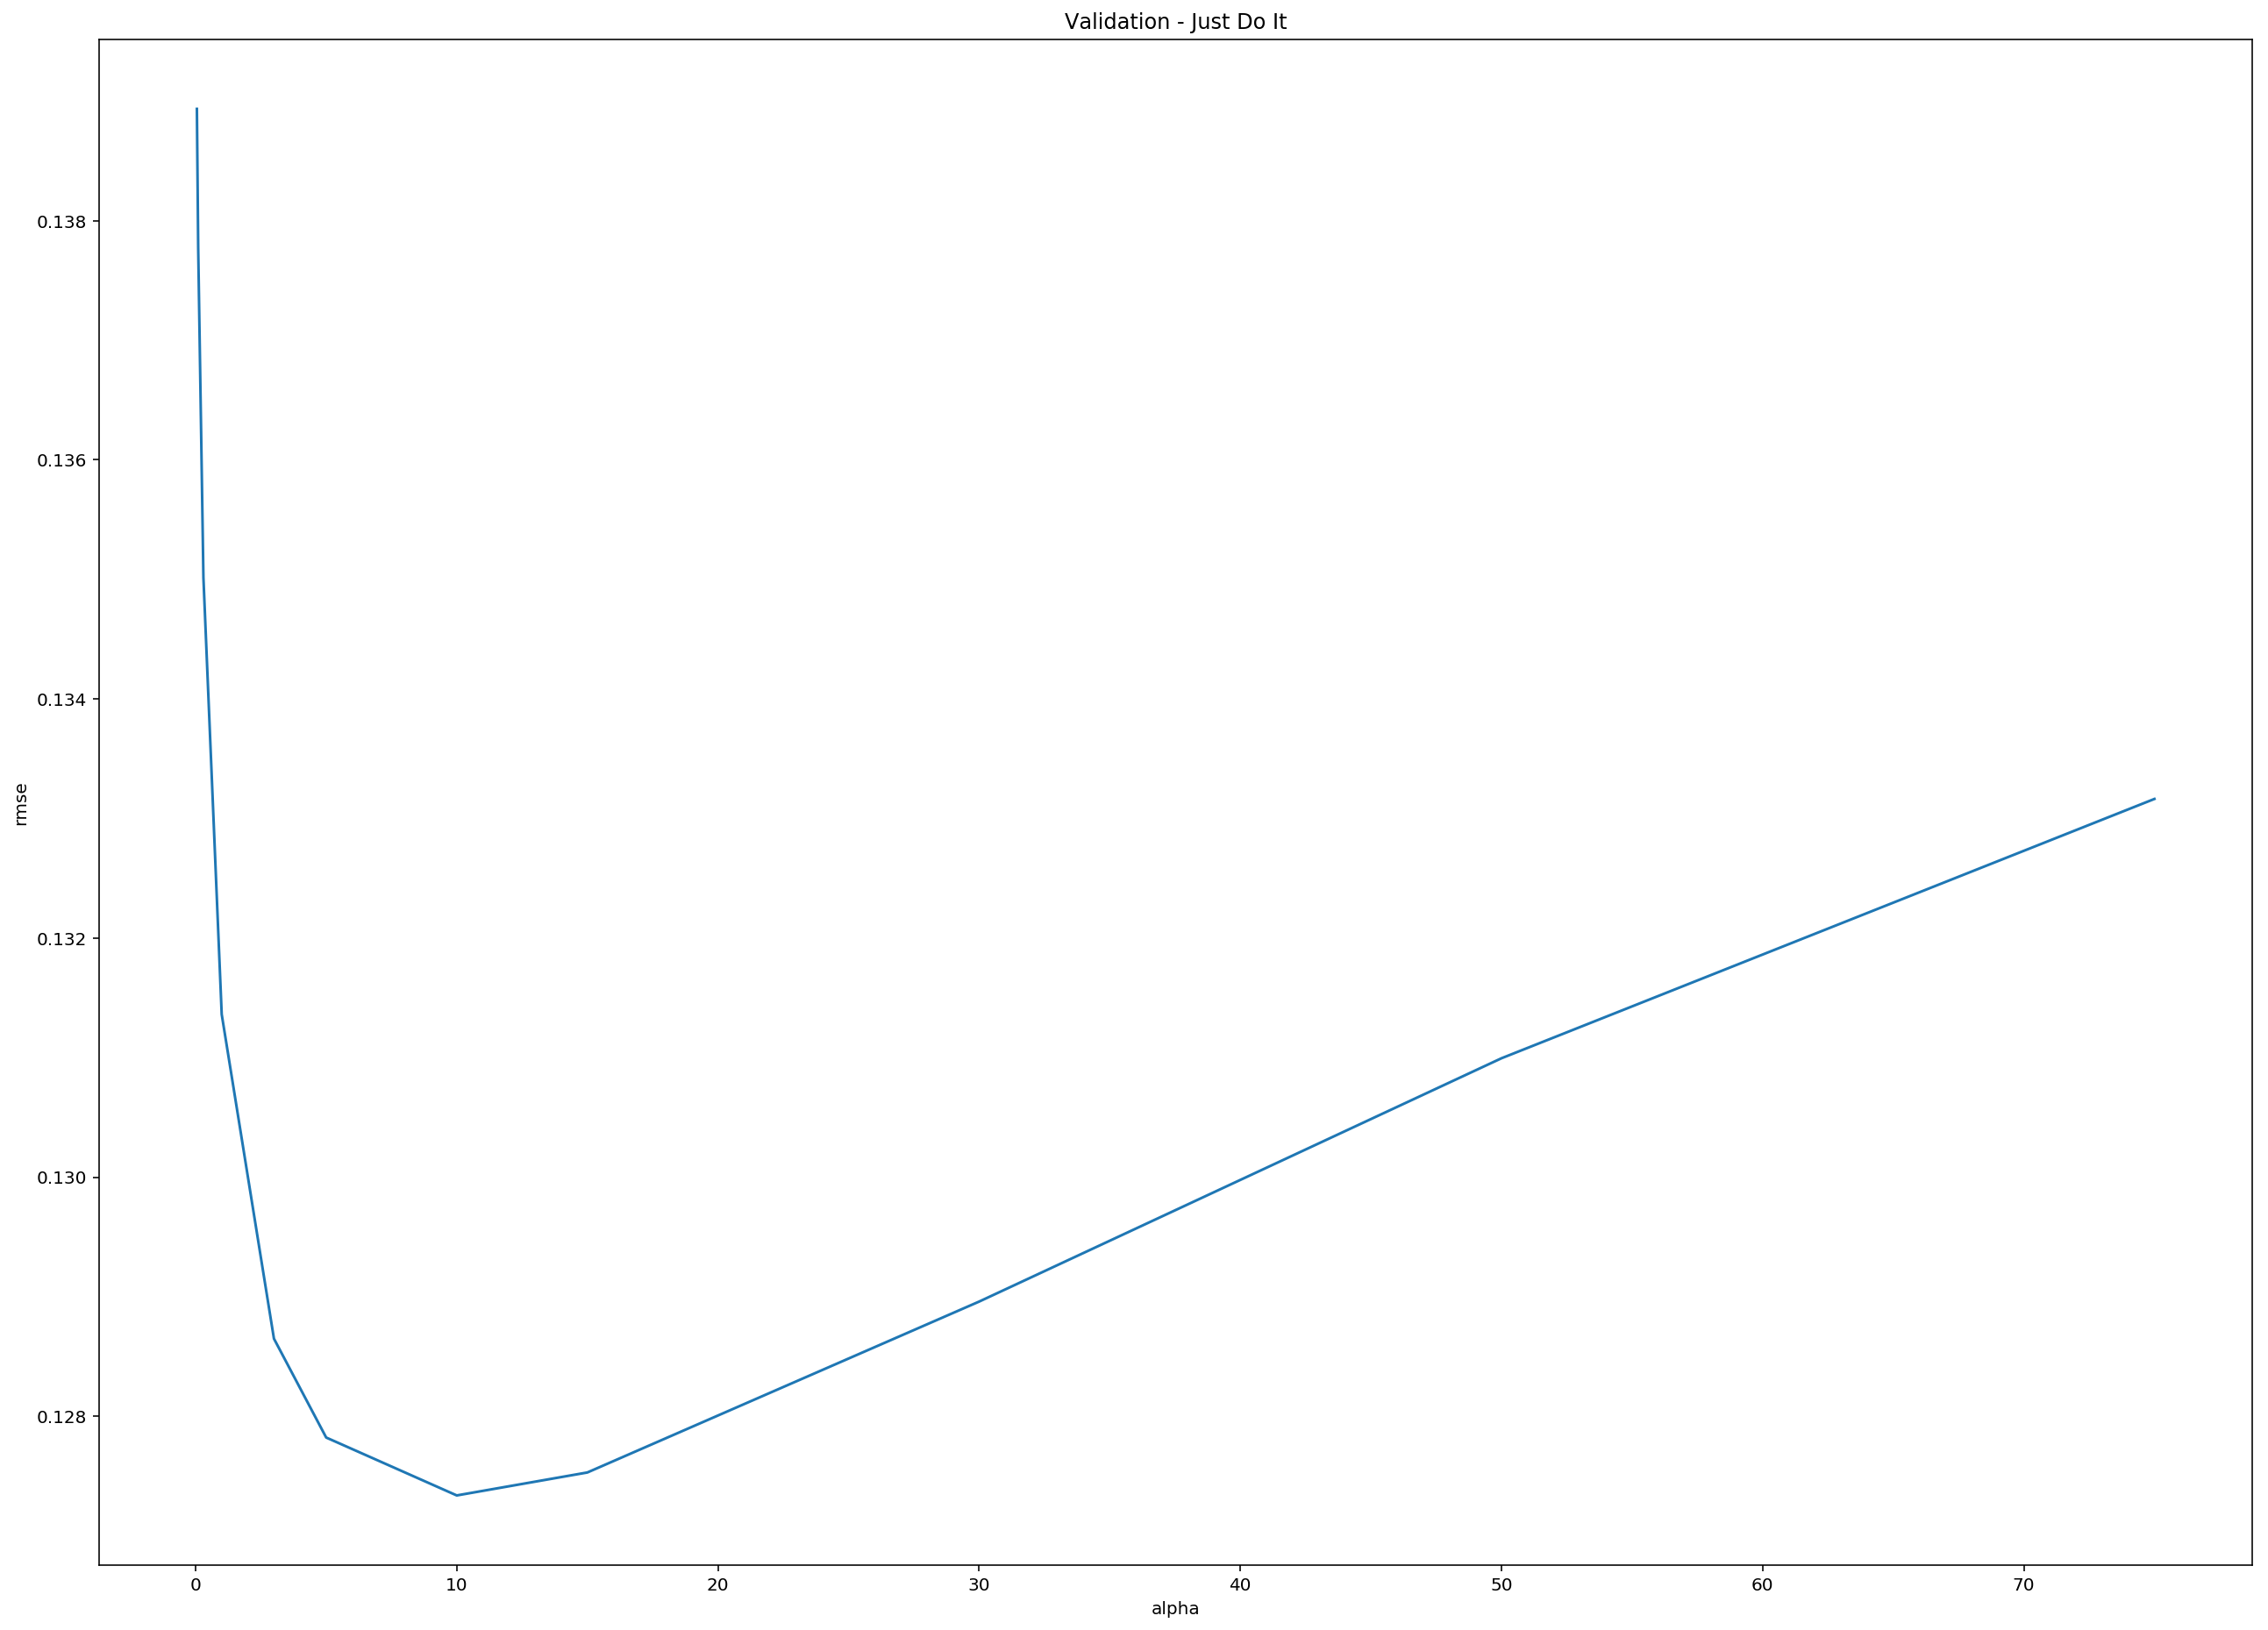

In [9]:
model_ridge = Ridge()
alphas = [0.05, 0.1, 0.3, 1, 3, 5, 10, 15, 30, 50, 75]
cv_ridge = [rmse_cv(Ridge(alpha = alpha)).mean() 
            for alpha in alphas]
cv_ridge = pd.Series(cv_ridge, index = alphas)
cv_ridge.plot(title = "Validation - Just Do It")
plt.xlabel("alpha")
plt.ylabel("rmse")

In [10]:
model_lasso = LassoCV(alphas = [1, 0.1, 0.001, 0.0005]).fit(X_train, y)

Text(0.5,1,u'Coefficients in the Lasso Model')

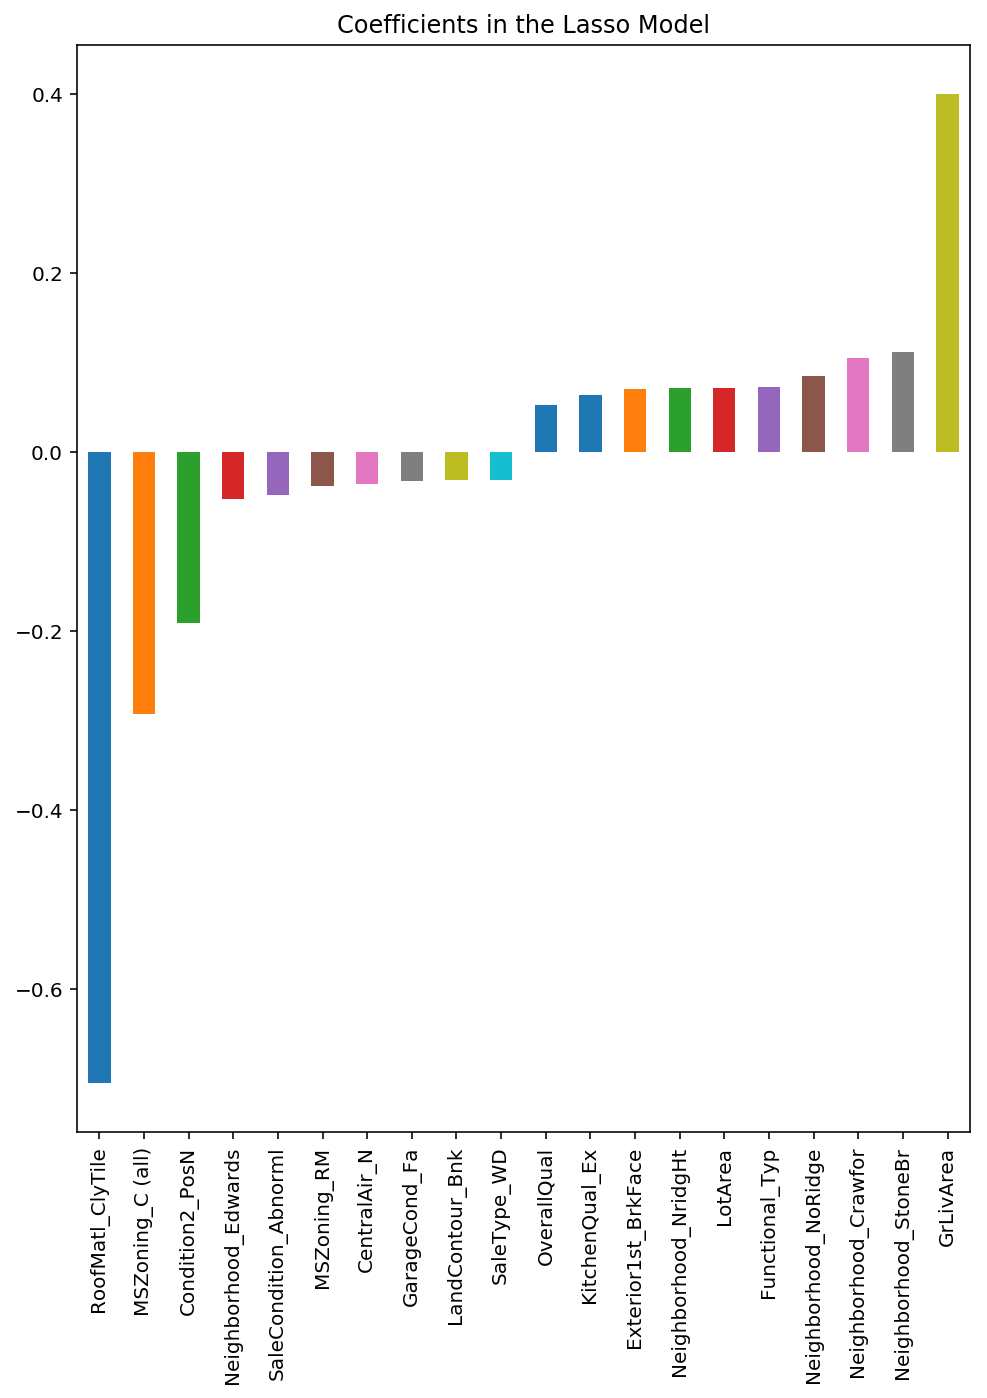

In [17]:
rmse_cv(model_lasso).mean()
coef = pd.Series(model_lasso.coef_, index = X_train.columns)
imp_coef = pd.concat([coef.sort_values().head(10),
                     coef.sort_values().tail(10)])
matplotlib.rcParams['figure.figsize'] = (8.0, 10.0)
imp_coef.plot(kind = "bar")
plt.title("Coefficients in the Lasso Model")

In [12]:
import xgboost as xgb
dtrain = xgb.DMatrix(X_train, label = y)
dtest = xgb.DMatrix(X_test)

In [13]:
print dtrain

In [21]:
predicts=model_lasso.predict(X_test)
print predicts

[ 11.69490559  11.92823243  12.10183291 ...,  12.03779924  11.68640318
  12.33887195]
